In [2]:
import pandas as pd
import numpy as np 
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Creating Hubei Dataset

In [3]:
deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\EnKF Sim + Data\time_series_covid19_deaths_global.csv")
recovered = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\EnKF Sim + Data\time_series_covid19_recovered_global.csv")
confirmed = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\EnKF Sim + Data\time_series_covid19_confirmed_global.csv")

# print(deaths.columns)
# print(deaths.head(2))

In [4]:
hubei_deaths = deaths[deaths['Province/State'] == 'Hubei']
#print(hubei_deaths.head())
hubei_recov = recovered[recovered['Province/State'] == 'Hubei']
hubei_confirm = confirmed[confirmed['Province/State'] == 'Hubei']
#print(hubei_recov.head())
# print(hubei_confirm.head())

In [5]:
# transpose so dates become index for merging
confirm_series = hubei_confirm.drop(
    columns=['Province/State','Country/Region','Lat','Long']
).T.squeeze().rename("Confirmed")
recovered_series = hubei_recov.drop(
    columns=['Province/State','Country/Region','Lat','Long']
).T.squeeze().rename("Recovered")
deaths_series = hubei_deaths.drop(
    columns=['Province/State','Country/Region','Lat','Long']
).T.squeeze().rename("Deaths")

# make index datetime 
confirm_series.index = pd.to_datetime(confirm_series.index)
recovered_series.index = pd.to_datetime(recovered_series.index)
deaths_series.index = pd.to_datetime(deaths_series.index)

# make all series match confirmed cases date index
recovered_series = recovered_series.reindex(confirm_series.index, fill_value=0)
deaths_series = deaths_series.reindex(confirm_series.index, fill_value=0)

hubei_df = pd.concat([confirm_series, recovered_series, deaths_series], axis=1)
hubei_df["Active"] = hubei_df["Confirmed"] - hubei_df["Recovered"] - hubei_df["Deaths"]
hubei_df = hubei_df.reset_index().rename(columns={'index': 'Date'})

print(hubei_df.head())


        Date  Confirmed  Recovered  Deaths  Active
0 2020-01-22        444         28      17     399
1 2020-01-23        444         28      17     399
2 2020-01-24        549         31      24     494
3 2020-01-25        761         32      40     689
4 2020-01-26       1058         42      52     964


C:\Users\msnin\AppData\Local\Temp\ipykernel_10548\132748199.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  confirm_series.index = pd.to_datetime(confirm_series.index)


In [6]:
# ADJUSTING TIMEFRAME OF DATA FOR SIMULATION

hubei_df['Date'] = pd.to_datetime(hubei_df['Date'])

beg_date = '2020-01-22' 
end_date = '2020-07-01' #includes both start and end date

filtered_df = hubei_df[(hubei_df['Date'] >= beg_date) & (hubei_df['Date'] <= end_date)].reset_index(drop=True)

print(filtered_df.head())

        Date  Confirmed  Recovered  Deaths  Active
0 2020-01-22        444         28      17     399
1 2020-01-23        444         28      17     399
2 2020-01-24        549         31      24     494
3 2020-01-25        761         32      40     689
4 2020-01-26       1058         42      52     964


# Actual simulation

In [7]:
H = np.array([
    [0, 1, 0, 0],  # I 
    [0, 0, 1, 0],  # R 
    [0, 0, 0, 1]   # D 
])

# paper parameters
n_ens = 200
Y_obs = filtered_df[['Active', 'Recovered', 'Deaths']].to_numpy(dtype = float) # measurement vector on data from our timeframe
T = len(Y_obs)  
N = 59000000  # Hubei population
t_lockdown = 5
dt = 1.0

alpha = 1.0
tol = 1e-3
converged_day = None

rng = np.random.default_rng(seed=100)

In [8]:
# Initial state from day 0
I0 = 399
R0 = 28
D0 = 17
S0 = max(N - I0 - R0 - D0, 0.0)
x0_mean = np.array([S0, I0, R0, D0])  # [S I R D]


def u(lo, hi, size):
    return rng.uniform(lo, hi, size)

def R_from_obs(y_obs): # paper given
    std_devs = 0.1 * np.maximum(y_obs, 1e-2)  
    return np.diag(std_devs ** 2)

def enforce_mass(state_ens, N): # to make sure system is closed st N = S + I + R + D
    np.maximum(state_ens, 0.0, out=state_ens) # always non negative
    total_IRD = state_ens[:, 1:].sum(axis=1)
    
    # sum(I+R+D) <= N, set S = N - (I+R+D)
    ok = total_IRD <= N
    state_ens[ok, 0] = N - total_IRD[ok]
    
    # if sum(I+R+D) > N, rescale I,R,D down to sum to N, set S=0
    over = ~ok
    if np.any(over):
        scale = (N / total_IRD[over])[:, None]
        state_ens[over, 1:] *= scale
        state_ens[over, 0] = 0.0
    return state_ens

# unif dist to sample params from
param_ens = np.column_stack([
    u(0.1,   0.9,   n_ens),  # beta0
    u(0.001, 0.002, n_ens),  # beta1
    u(5.0,   20.0,  n_ens),  # tau_beta
    u(0.001, 0.02,  n_ens),  # gamma0
    u(0.01,  0.1,   n_ens),  # gamma1
    u(7.0,   40.0,  n_ens),  # tau_gamma
    u(0.001, 0.01,  n_ens),  # delta0
    u(0.001, 0.002, n_ens),  # delta1
    u(7.0,   20.0,  n_ens),  # tau_delta
])


In [9]:
ensemble_states_hist = np.full((T, n_ens, 4), np.nan)
ensemble_params_hist = np.full((T, n_ens, 9), np.nan)

def sird_step(state, param, N, day, t_lockdown, dt):
    S, I, R, D = state
    beta0, beta1, tau_beta, gamma0, gamma1, tau_gamma, delta0, delta1, tau_delta = param

    # BETA
    if day < t_lockdown:
        beta = beta0
    else:
        beta = beta0 * np.exp(-(day - t_lockdown)/tau_beta) + beta1

    # GAMMA
    gamma = gamma0 + gamma1 / (1 + np.exp(- (day - tau_gamma)))

    # DELTA
    if day < t_lockdown:
        delta = delta0
    else:
        delta = delta0 * np.exp(-(day - t_lockdown)/tau_delta) + delta1

    dS = - beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dR = gamma * I
    dD = delta * I

    S_new = max(S + dS * dt, 0)
    I_new = max(I + dI * dt, 0)
    R_new = max(R + dR * dt, 0)
    D_new = max(D + dD * dt, 0)

    return np.array([S_new, I_new, R_new, D_new])

def predict_measurement(state_ensemble):
    return (H @ state_ensemble.T).T

algo 1. addt. code so multiple passes can be done

In [10]:
max_passes = 10
pass_idx = 0
total_cycles = 0
converged = False
converged_day = None 
num_assm_cycle = 0
converg_in_row = 3  # number of consecutive days to check
converg_counter = 0


while pass_idx < max_passes and not converged: # NEW PASS
        pass_idx += 1
        # reinit ensemble with perterbations
        state_ens = np.zeros((n_ens, 4))
        for i in range(n_ens):
            perturb = 1 + 0.2 * rng.normal(size=3)  # only perturb I, R, D
            IRD = np.maximum(x0_mean[1:] * perturb, 0)
            S = max(N - IRD.sum(), 0)
            state_ens[i] = np.hstack([S, IRD])
        state_ens = enforce_mass(state_ens, N)
        
        # reinit parmams
        param_ens = np.column_stack([
            u(0.1,   0.9,   n_ens),  # beta0
            u(0.001, 0.002, n_ens),  # beta1
            u(5.0,   20.0,  n_ens),  # tau_beta
            u(0.001, 0.02,  n_ens),  # gamma0
            u(0.01,  0.1,   n_ens),  # gamma1
            u(7.0,   40.0,  n_ens),  # tau_gamma
            u(0.001, 0.01,  n_ens),  # delta0
            u(0.001, 0.002, n_ens),  # delta1
            u(7.0,   20.0,  n_ens),  # tau_delta
        ])
        
        converged_day = None
          
        for k in range(T):
            # 1: Forecast step
            num_assm_cycle += 1
            for i in range(n_ens):
                state_ens[i] = sird_step(state_ens[i], param_ens[i], N, k, t_lockdown, dt)
            state_ens = enforce_mass(state_ens, N)

            # Store ensembles
            ensemble_states_hist[k] = state_ens
            ensemble_params_hist[k] = param_ens

            # 2: Measurement prediction
            meas_pred = predict_measurement(state_ens)  # shape (n_ens, 3)

            # 3: Observation perturbation
            y_obs_k = Y_obs[k]
            Rk = R_from_obs(y_obs_k)
            obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

            # 4: Augment state and parameters
            aug_ens = np.hstack([state_ens, param_ens])  # shape (n_ens, 13)
            aug_mean = np.mean(aug_ens, axis=0)
            meas_mean = np.mean(meas_pred, axis=0)

            # 5: Compute perturbations
            X = aug_ens - aug_mean  # shape (n_ens, 13)
            Y = meas_pred - meas_mean  # shape (n_ens, 3)

            # 6: Covariance matrices
            C_xy = (X.T @ Y) / (n_ens - 1)      # shape (13, 3)
            C_yy = (Y.T @ Y) / (n_ens - 1)      # shape (3, 3)

            # 7: Kalman gain
            Kk = C_xy @ np.linalg.inv(C_yy + Rk)

            # 8: Analysis update
            for i in range(n_ens):
                innovation = obs_perturbed[i] - meas_pred[i]
                aug_update = aug_ens[i] + alpha * (Kk @ innovation)
                state_ens[i] = aug_update[:4]
                param_ens[i] = aug_update[4:]
            state_ens = enforce_mass(state_ens, N)

            # Persist ensembles for this step
            ensemble_states_hist[k] = state_ens
            ensemble_params_hist[k] = param_ens

            # 9: Check convergence 
            if k > 0:
                prev_mean_theta = np.mean(ensemble_params_hist[k-1], axis=0)
                curr_mean_theta = np.mean(param_ens, axis=0)
                rel_change = np.linalg.norm(curr_mean_theta - prev_mean_theta) / (np.linalg.norm(prev_mean_theta) + 1e-9)
                if rel_change < tol:
                    converg_counter += 1
                    
                    if converg_counter == converg_in_row:
                        converged_day = k
                        print(f"Pass {pass_idx} converged at day {converged_day}")
                        print(f'Converged after {num_assm_cycle} assimilation cycles')
                        break
                else: 
                    converg_counter = 0

        # Extract mean states up to last_day
        last_day = converged_day if converged_day is not None else T - 1
        mean_states = np.nanmean(ensemble_states_hist[: last_day + 1], axis=1)
        mean_S = mean_states[:, 0]
        
        total_cycles += (converged_day + 1) if converged_day is not None else T

        if converged_day is not None:
            converged = True
        else:
            print(f"Pass {pass_idx} did not converge after {T} days, restarting with new ensemble")

if not converged:
    print(f"Did not converge after {max_passes} passes (total cycles = {total_cycles})")


Pass 1 converged at day 107
Converged after 108 assimilation cycles


In [11]:
# get observed data and predictions
actual_I = Y_obs[: last_day + 1, 0]
actual_R = Y_obs[: last_day + 1, 1]
actual_D = Y_obs[: last_day + 1, 2]

pred_I = mean_states[:, 1]
pred_R = mean_states[:, 2]
pred_D = mean_states[:, 3]

def clean_nans(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return y_true[mask], y_pred[mask]

actual_I, pred_I = clean_nans(actual_I, pred_I)
actual_R, pred_R = clean_nans(actual_R, pred_R)
actual_D, pred_D = clean_nans(actual_D, pred_D)

Infected:   R^2=0.9801, RMSE=2339.28
Recovered:  R^2=0.9663, RMSE=4843.98
Deceased:   R^2=0.8609, RMSE=517.37
convergence 107
converged after 108 assim cycles


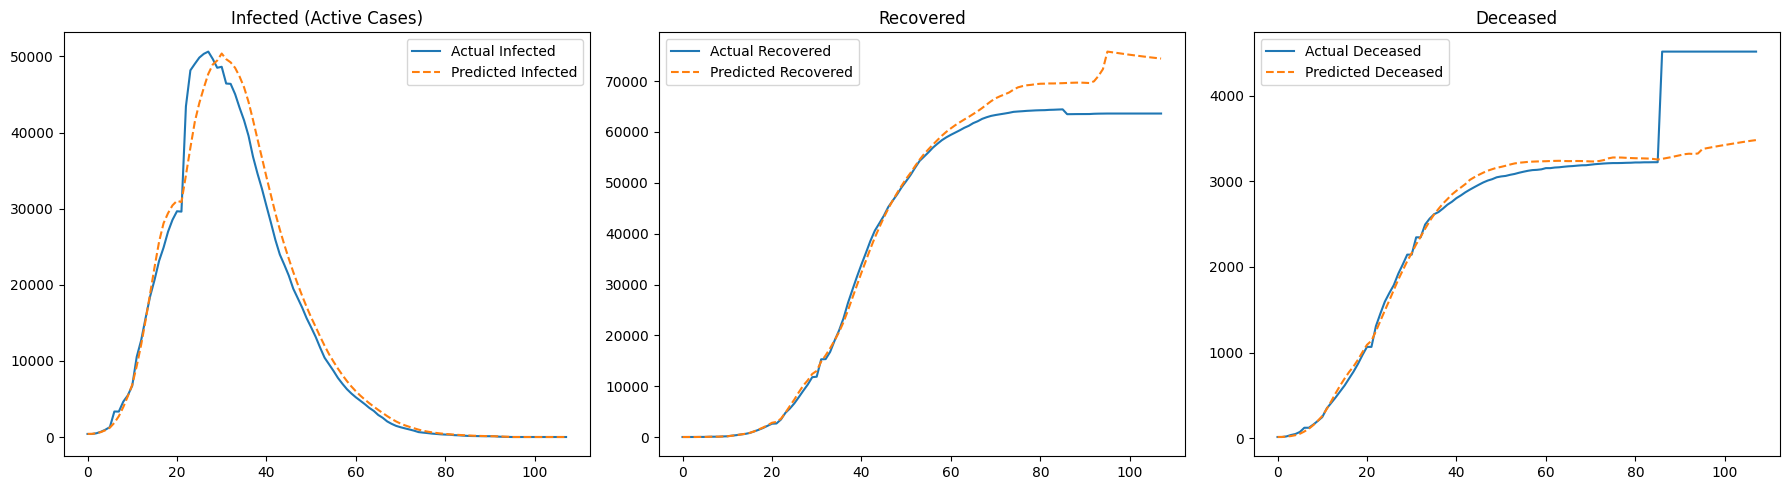

In [12]:
print(f"Infected:   R^2={r2_score(actual_I, pred_I):.4f}, RMSE={root_mean_squared_error(actual_I, pred_I):.2f}")
print(f"Recovered:  R^2={r2_score(actual_R, pred_R):.4f}, RMSE={root_mean_squared_error(actual_R, pred_R):.2f}")
print(f"Deceased:   R^2={r2_score(actual_D, pred_D):.4f}, RMSE={root_mean_squared_error(actual_D, pred_D):.2f}")
print('convergence', converged_day)
print(f'converged after {num_assm_cycle} assim cycles')

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(actual_I, label='Actual Infected')
plt.plot(pred_I, '--', label='Predicted Infected')
plt.legend()
plt.title('Infected (Active Cases)')

plt.subplot(1,3,2)
plt.plot(actual_R, label='Actual Recovered')
plt.plot(pred_R, '--', label='Predicted Recovered')
plt.legend()
plt.title('Recovered')

plt.subplot(1,3,3)
plt.plot(actual_D, label='Actual Deceased')
plt.plot(pred_D, '--', label='Predicted Deceased')
plt.legend()
plt.title('Deceased')

plt.tight_layout()
plt.show()

plot each greek over time

C:\Users\msnin\AppData\Local\Temp\ipykernel_10548\2018549818.py:4: RuntimeWarning: Mean of empty slice
  mean_params_time = np.nanmean(ensemble_params_hist, axis=1)  # shape (T, 9)


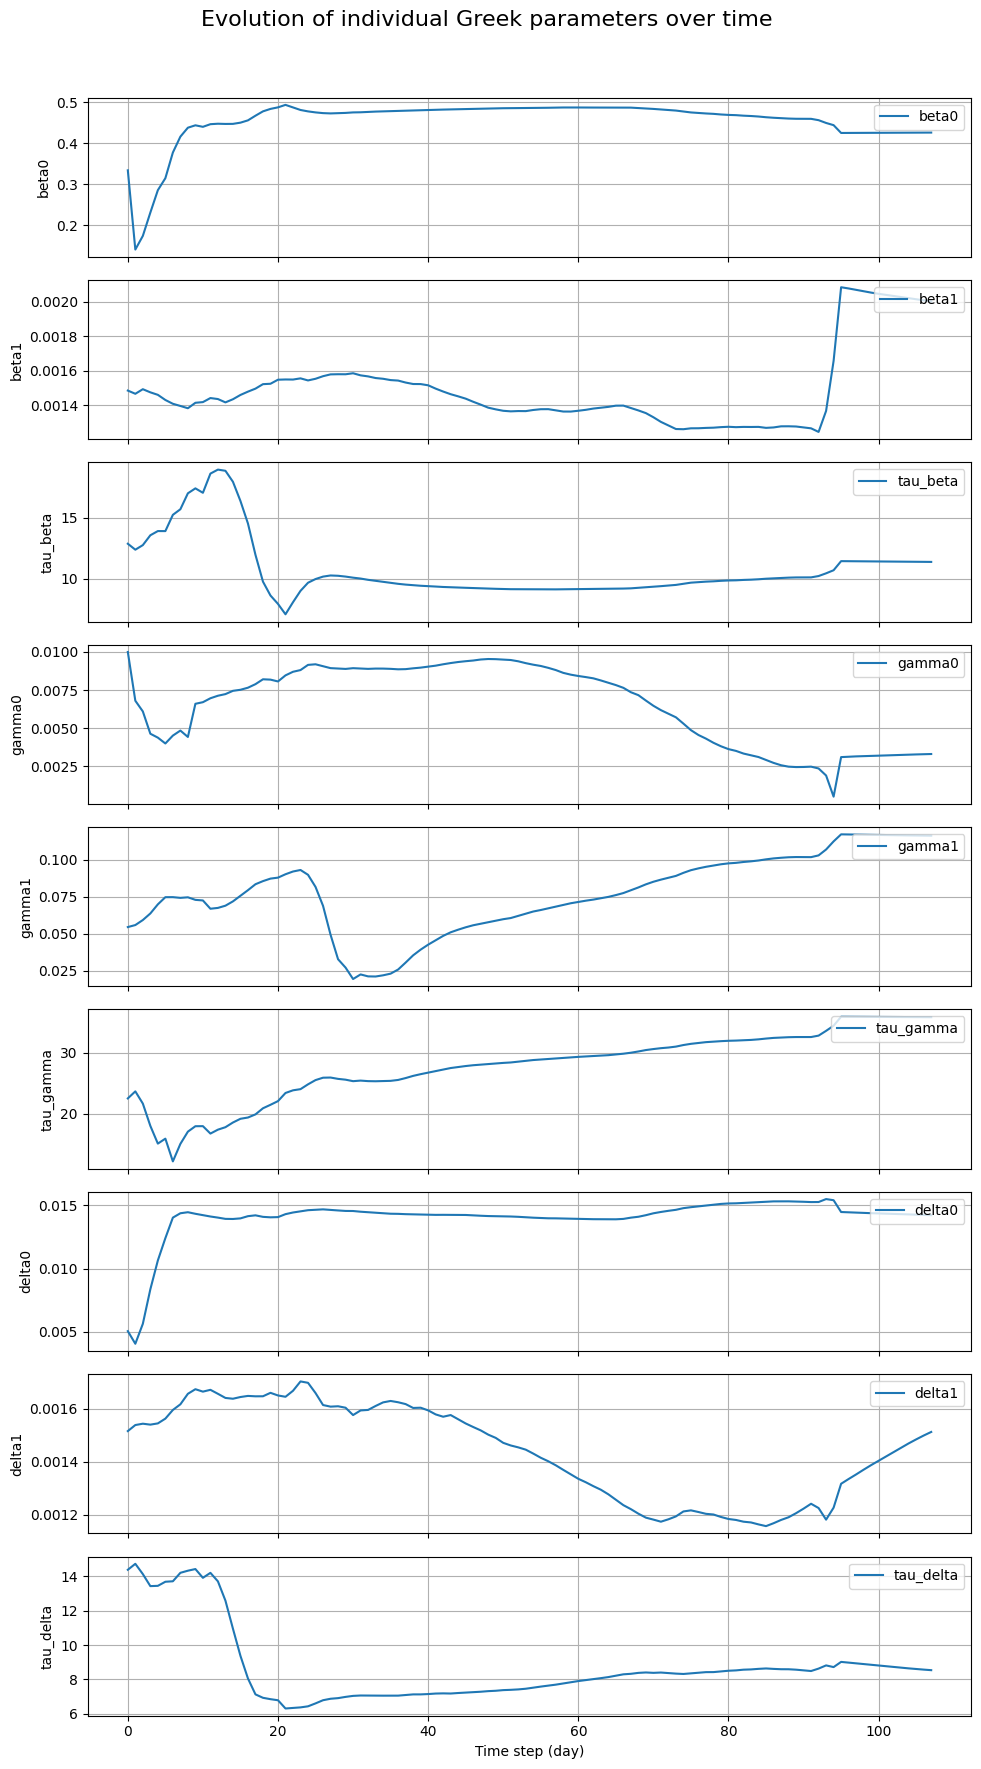

In [13]:
import matplotlib.pyplot as plt
import numpy as np

mean_params_time = np.nanmean(ensemble_params_hist, axis=1)  # shape (T, 9)

param_names = [
    'beta0', 'beta1', 'tau_beta',
    'gamma0', 'gamma1', 'tau_gamma',
    'delta0', 'delta1', 'tau_delta'
]

T = mean_params_time.shape[0]
time_steps = np.arange(T)

fig, axes = plt.subplots(9, 1, figsize=(10, 18), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(time_steps, mean_params_time[:, i], label=param_names[i])
    ax.set_ylabel(param_names[i])
    ax.legend(loc='upper right')
    ax.grid(True)

axes[-1].set_xlabel('Time step (day)')
plt.suptitle('Evolution of individual Greek parameters over time', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Averaging sim over multiple seeds

In [14]:
# SIM CHECKS IF CONVERGENCE FOR 3 DAYS IN A ROW 

# inits that stay constant
import numpy as np
import pandas as pd

H = np.array([
    [0, 1, 0, 0],  # I 
    [0, 0, 1, 0],  # R 
    [0, 0, 0, 1]   # D 
])

n_ens = 200
# Assumes 'filtered_df' is defined elsewhere
Y_obs = filtered_df[['Active', 'Recovered', 'Deaths']].to_numpy(dtype = float)
T = len(Y_obs)
N = 59000000  # Hubei population
t_lockdown = 5
dt = 1.0

alpha = 1.0
tol = 1e-3
ens_perturb = 0.1

I0 = 399
R0 = 28
D0 = 17
S0 = max(N - I0 - R0 - D0, 0.0)
x0_mean = np.array([S0, I0, R0, D0])  # [S I R D]

def R_from_obs(y_obs): # R diag matrix, 0.1 set by paper
    std_devs = 0.01 * np.maximum(y_obs, 1e-2)
    return np.diag(std_devs ** 2)

def enforce_mass(state_ens, N):
    np.maximum(state_ens, 0.0, out=state_ens)
    total_IRD = state_ens[:, 1:].sum(axis=1)
    ok = total_IRD <= N
    state_ens[ok, 0] = N - total_IRD[ok]
    over = ~ok
    if np.any(over):
        scale = (N / total_IRD[over])[:, None]
        state_ens[over, 1:] *= scale
        state_ens[over, 0] = 0.0
    return state_ens

def sird_step(state, param, N, day, t_lockdown, dt):
    S, I, R, D = state
    beta0, beta1, tau_beta, gamma0, gamma1, tau_gamma, delta0, delta1, tau_delta = param
    beta = beta0 if day < t_lockdown else beta0 * np.exp(-(day - t_lockdown)/tau_beta) + beta1
    gamma = gamma0 + gamma1 / (1 + np.exp(- (day - tau_gamma)))
    delta = delta0 if day < t_lockdown else delta0 * np.exp(-(day - t_lockdown)/tau_delta) + delta1
    dS = - beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dR = gamma * I
    dD = delta * I
    S_new = max(S + dS * dt, 0)
    I_new = max(I + dI * dt, 0)
    R_new = max(R + dR * dt, 0)
    D_new = max(D + dD * dt, 0)
    return np.array([S_new, I_new, R_new, D_new])

def predict_measurement(state_ensemble):
    return (H @ state_ensemble.T).T

def clean_nans(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return y_true[mask], y_pred[mask]

In [15]:
from sklearn.metrics import root_mean_squared_error, r2_score

def run_enkf_for_seed(sim_seed):
    rng = np.random.default_rng(sim_seed)
    def u(lo, hi, size):
        return rng.uniform(lo, hi, size)
    # Ensemble initialization
    state_ens = np.zeros((n_ens, 4))
    for i in range(n_ens):
        perturb = 1 + ens_perturb * rng.normal(size=3)
        IRD = np.maximum(x0_mean[1:] * perturb, 0)
        S = max(N - IRD.sum(), 0)
        state_ens[i] = np.hstack([S, IRD])
    state_ens = enforce_mass(state_ens, N)
    param_ens = np.column_stack([
        u(0.1,   0.9,   n_ens),
        u(0.001, 0.002, n_ens),
        u(5.0,   20.0,  n_ens),
        u(0.001, 0.02,  n_ens),
        u(0.01,  0.1,   n_ens),
        u(7.0,   40.0,  n_ens),
        u(0.001, 0.01,  n_ens),
        u(0.001, 0.002, n_ens),
        u(7.0,   20.0,  n_ens),
    ])
    
    ensemble_states_hist = np.full((T, n_ens, 4), np.nan)
    ensemble_params_hist = np.full((T, n_ens, 9), np.nan)
    
    max_passes = 10
    pass_idx = 0
    total_cycles = 0
    num_assm_cycle = 0
    converged = False
    converged_day = None 
    converg_in_row = 1
    converg_counter = 0

    while pass_idx < max_passes and not converged:
        pass_idx += 1
        state_ens = np.zeros((n_ens, 4))
        for i in range(n_ens):
            perturb = 1 + ens_perturb * rng.normal(size=3)
            IRD = np.maximum(x0_mean[1:] * perturb, 0)
            S = max(N - IRD.sum(), 0)
            state_ens[i] = np.hstack([S, IRD])
        state_ens = enforce_mass(state_ens, N)
        param_ens = np.column_stack([
            u(0.1,   0.9,   n_ens),
            u(0.001, 0.002, n_ens),
            u(5.0,   20.0,  n_ens),
            u(0.001, 0.02,  n_ens),
            u(0.01,  0.1,   n_ens),
            u(7.0,   40.0,  n_ens),
            u(0.001, 0.01,  n_ens),
            u(0.001, 0.002, n_ens),
            u(7.0,   20.0,  n_ens),
        ])
        converged_day = None

        for k in range(T):
            num_assm_cycle += 1
            for i in range(n_ens):
                state_ens[i] = sird_step(state_ens[i], param_ens[i], N, k, t_lockdown, dt)
            state_ens = enforce_mass(state_ens, N)

            ensemble_states_hist[k] = state_ens
            ensemble_params_hist[k] = param_ens

            meas_pred = predict_measurement(state_ens)
            y_obs_k = Y_obs[k]
            Rk = R_from_obs(y_obs_k)
            obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

            aug_ens = np.hstack([state_ens, param_ens])
            aug_mean = np.mean(aug_ens, axis=0)
            meas_mean = np.mean(meas_pred, axis=0)

            X = aug_ens - aug_mean
            Y = meas_pred - meas_mean
            C_xy = (X.T @ Y) / (n_ens - 1)
            C_yy = (Y.T @ Y) / (n_ens - 1)

            Kk = C_xy @ np.linalg.inv(C_yy + Rk)
            for i in range(n_ens):
                innovation = obs_perturbed[i] - meas_pred[i]
                aug_update = aug_ens[i] + alpha * (Kk @ innovation)
                state_ens[i] = aug_update[:4]
                param_ens[i] = aug_update[4:]
            state_ens = enforce_mass(state_ens, N)

            ensemble_states_hist[k] = state_ens
            ensemble_params_hist[k] = param_ens

            if k > 0:
                prev_mean_theta = np.mean(ensemble_params_hist[k-1], axis=0)
                curr_mean_theta = np.mean(param_ens, axis=0)
                rel_change = np.linalg.norm(curr_mean_theta - prev_mean_theta, ord=np.inf) / (np.linalg.norm(prev_mean_theta) + 1e-9)
                if rel_change < tol:
                    converg_counter += 1
                    if converg_counter == converg_in_row:
                        converged_day = k
                        break
                else:
                    converg_counter = 0

        last_day = converged_day if converged_day is not None else T - 1
        total_cycles += (converged_day + 1) if converged_day is not None else T
        mean_states = np.nanmean(ensemble_states_hist[: last_day + 1], axis=1)
        
        if converged_day is not None:
            converged = True

    actual_I = Y_obs[: last_day + 1, 0]
    actual_R = Y_obs[: last_day + 1, 1]
    actual_D = Y_obs[: last_day + 1, 2]
    pred_I = mean_states[:, 1]
    pred_R = mean_states[:, 2]
    pred_D = mean_states[:, 3]
    actual_I, pred_I = clean_nans(actual_I, pred_I)
    actual_R, pred_R = clean_nans(actual_R, pred_R)
    actual_D, pred_D = clean_nans(actual_D, pred_D)
    
    rmse_I = np.sqrt(root_mean_squared_error(actual_I, pred_I))
    r2_I = r2_score(actual_I, pred_I)
    rmse_R = np.sqrt(root_mean_squared_error(actual_R, pred_R))
    r2_R = r2_score(actual_R, pred_R)
    rmse_D = np.sqrt(root_mean_squared_error(actual_D, pred_D))
    r2_D = r2_score(actual_D, pred_D)
    
    return {
        'rmse_I': rmse_I,
        'r2_I': r2_I,
        'rmse_R': rmse_R,
        'r2_R': r2_R,
        'rmse_D': rmse_D,
        'r2_D': r2_D,
        'total_cycles': total_cycles,
        'converged_day': converged_day,
        'susceptible': mean_S
        # Optionally add series for post analysis (not needed for averaging)
    }


In [16]:
seeds = np.arange(10, 40)  # not inclusive of 40

results = []
for seed in seeds:
    res = run_enkf_for_seed(seed)
    results.append(res)

# Extract metrics from results
total_cycles_list = [r['total_cycles'] for r in results]
rmse_I_list = [r['rmse_I'] for r in results]
r2_I_list   = [r['r2_I'] for r in results]
rmse_R_list = [r['rmse_R'] for r in results]
r2_R_list   = [r['r2_R'] for r in results]
rmse_D_list = [r['rmse_D'] for r in results]
r2_D_list   = [r['r2_D'] for r in results]

print(f"Mean assimilation cycles: {np.mean(total_cycles_list):.2f} ± {np.std(total_cycles_list):.2f}")

print("Infected (I):   RMSE mean {:.2f} ± {:.2f},   R² mean {:.4f} ± {:.4f}".format(
    np.mean(rmse_I_list), np.std(rmse_I_list), np.mean(r2_I_list), np.std(r2_I_list)))

print("Recovered (R):  RMSE mean {:.2f} ± {:.2f},   R² mean {:.4f} ± {:.4f}".format(
    np.mean(rmse_R_list), np.std(rmse_R_list), np.mean(r2_R_list), np.std(r2_R_list)))

print("Deceased (D):   RMSE mean {:.2f} ± {:.2f},   R² mean {:.4f} ± {:.4f}".format(
    np.mean(rmse_D_list), np.std(rmse_D_list), np.mean(r2_D_list), np.std(r2_D_list)))


C:\Users\msnin\AppData\Local\Temp\ipykernel_10548\1347119551.py:50: RuntimeWarning: overflow encountered in exp
  beta = beta0 if day < t_lockdown else beta0 * np.exp(-(day - t_lockdown)/tau_beta) + beta1
C:\Users\msnin\AppData\Local\Temp\ipykernel_10548\1347119551.py:43: RuntimeWarning: invalid value encountered in multiply
  state_ens[over, 1:] *= scale
C:\Users\msnin\AppData\Local\Temp\ipykernel_10548\688144718.py:109: RuntimeWarning: Mean of empty slice
  mean_states = np.nanmean(ensemble_states_hist[: last_day + 1], axis=1)
C:\Users\msnin\AppData\Local\Temp\ipykernel_10548\1347119551.py:52: RuntimeWarning: overflow encountered in exp
  delta = delta0 if day < t_lockdown else delta0 * np.exp(-(day - t_lockdown)/tau_delta) + delta1
C:\Users\msnin\AppData\Local\Temp\ipykernel_10548\1347119551.py:43: RuntimeWarning: invalid value encountered in multiply
  state_ens[over, 1:] *= scale
C:\Users\msnin\AppData\Local\Temp\ipykernel_10548\688144718.py:109: RuntimeWarning: Mean of empty slic

Mean assimilation cycles: 496.40 ± 346.74
Infected (I):   RMSE mean 75.07 ± 22.22,   R² mean 0.8218 ± 0.1814
Recovered (R):  RMSE mean 112.24 ± 42.02,   R² mean 0.5620 ± 0.4449
Deceased (D):   RMSE mean 19.97 ± 5.17,   R² mean 0.8740 ± 0.0766


In [17]:
print(total_cycles_list)

[438, 249, 707, 928, 82, 77, 583, 281, 603, 615, 159, 416, 412, 558, 558, 432, 1262, 705, 658, 226, 1546, 247, 74, 583, 576, 1065, 105, 254, 259, 234]


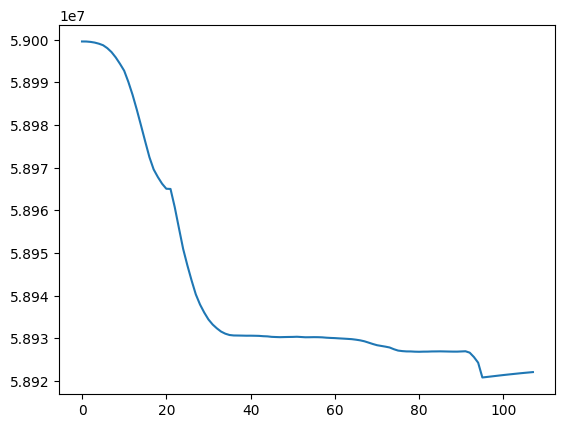

In [18]:
plt.plot(mean_S)

# Rollover

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

forecast_horizon = 10
train_start = pd.Timestamp('2020-01-22')
first_train_end = pd.Timestamp('2020-03-10')
last_train_end = pd.Timestamp('2020-03-20')

N = 59000000  # Hubei population
n_ens = 500
dt = 1.0
t_lockdown = 5
alpha = 1.2
rng = np.random.default_rng(seed=100)

H = np.array([
    [0, 1, 0, 0],  # I
    [0, 0, 1, 0],  # R
    [0, 0, 0, 1],  # D
])

def safe_exp(x):
    return np.exp(np.clip(x, -700, 700))

def enforce_mass(state_ens, N):
    np.maximum(state_ens, 0.0, out=state_ens)  # Non-negativity
    total_IRD = state_ens[:, 1:].sum(axis=1)
    ok = total_IRD <= N
    state_ens[ok, 0] = N - total_IRD[ok]
    over = ~ok
    if np.any(over):
        scale = (N / total_IRD[over])[:, None]
        state_ens[over, 1:] *= scale
        state_ens[over, 0] = 0.0
    return state_ens

def R_from_obs(y_obs):
    std_devs = 0.1 * np.maximum(y_obs, 1e-2)
    return np.diag(std_devs ** 2)

def sird_step(state, param, N, day, t_lockdown, dt):
    S, I, R, D = state
    beta0, beta1, tau_beta, gamma0, gamma1, tau_gamma, delta0, delta1, tau_delta = param
    beta = beta0 if day < t_lockdown else beta0 * safe_exp(-(day - t_lockdown)/tau_beta) + beta1
    gamma = gamma0 + gamma1 / (1 + safe_exp(- (day - tau_gamma)))
    delta = delta0 if day < t_lockdown else delta0 * safe_exp(-(day - t_lockdown)/tau_delta) + delta1
    dS = - beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dR = gamma * I
    dD = delta * I
    S_new = max(S + dS * dt, 0)
    I_new = max(I + dI * dt, 0)
    R_new = max(R + dR * dt, 0)
    D_new = max(D + dD * dt, 0)
    return np.array([S_new, I_new, R_new, D_new])

def sird_step_vectorized(states_ens, params_ens, N, day, t_lockdown, dt):
    S = states_ens[:, 0]
    I = states_ens[:, 1]
    R = states_ens[:, 2]
    D = states_ens[:, 3]
    beta0 = params_ens[:, 0]
    beta1 = params_ens[:, 1]
    tau_beta = params_ens[:, 2]
    gamma0 = params_ens[:, 3]
    gamma1 = params_ens[:, 4]
    tau_gamma = params_ens[:, 5]
    delta0 = params_ens[:, 6]
    delta1 = params_ens[:, 7]
    tau_delta = params_ens[:, 8]
    beta = np.where(day < t_lockdown,
                    beta0, beta0 * safe_exp(-(day - t_lockdown)/tau_beta) + beta1)
    gamma = gamma0 + gamma1 / (1 + safe_exp(- (day - tau_gamma)))
    delta = np.where(day < t_lockdown,
                     delta0, delta0 * safe_exp(-(day - t_lockdown)/tau_delta) + delta1)
    dS = - beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dR = gamma * I
    dD = delta * I
    S_new = np.maximum(S + dS * dt, 0)
    I_new = np.maximum(I + dI * dt, 0)
    R_new = np.maximum(R + dR * dt, 0)
    D_new = np.maximum(D + dD * dt, 0)
    updated_states = np.stack([S_new, I_new, R_new, D_new], axis=1)
    updated_states = enforce_mass(updated_states, N)
    return updated_states

def initialize_ensemble():
    x0_mean = np.array([N - 399 - 28 - 17, 399, 28, 17])
    state_ens = np.zeros((n_ens, 4))
    for i in range(n_ens):
        perturb = 1 + 0.2 * rng.normal(size=3)
        IRD = np.maximum(x0_mean[1:] * perturb, 0)
        S = max(N - IRD.sum(), 0)
        state_ens[i] = np.hstack([S, IRD])
    state_ens = enforce_mass(state_ens, N)
    param_ens = np.column_stack([
        rng.uniform(0.1, 0.9, n_ens),
        rng.uniform(0.001, 0.002, n_ens),
        rng.uniform(5.0, 20.0, n_ens),
        rng.uniform(0.001, 0.02, n_ens),
        rng.uniform(0.01, 0.1, n_ens),
        rng.uniform(7.0, 40.0, n_ens),
        rng.uniform(0.001, 0.01, n_ens),
        rng.uniform(0.001, 0.002, n_ens),
        rng.uniform(7.0, 20.0, n_ens),
    ])
    return state_ens, param_ens

def enkf_update_one_day(state_ens, param_ens, y_obs, day_index):
    for i in range(n_ens):
        state_ens[i] = sird_step(state_ens[i], param_ens[i], N, day_index, t_lockdown, dt)
    state_ens = enforce_mass(state_ens, N)
    meas_pred = (H @ state_ens.T).T
    Rk = R_from_obs(y_obs)
    obs_perturbed = rng.multivariate_normal(y_obs, Rk, size=n_ens)
    aug_ens = np.hstack([state_ens, param_ens])
    aug_mean = np.mean(aug_ens, axis=0)
    meas_mean = np.mean(meas_pred, axis=0)
    X = aug_ens - aug_mean
    Y = meas_pred - meas_mean
    C_xy = (X.T @ Y) / (n_ens - 1)
    C_yy = (Y.T @ Y) / (n_ens - 1)
    Kk = C_xy @ np.linalg.inv(C_yy + Rk)
    for i in range(n_ens):
        innovation = obs_perturbed[i] - meas_pred[i]
        aug_update = aug_ens[i] + alpha * (Kk @ innovation)
        state_ens[i] = aug_update[:4]
        param_ens[i] = aug_update[4:]
    state_ens = enforce_mass(state_ens, N)
    return state_ens, param_ens

param_noise_stds = np.array([
    0.01,   # beta0
    0.0001, # beta1
    0.2,    # tau_beta
    0.001,  # gamma0
    0.003,  # gamma1
    0.4,    # tau_gamma
    0.0002, # delta0
    0.0001, # delta1
    0.2,    # tau_delta
]) 

state_ens_init, param_ens_init = initialize_ensemble()
rolling_forecasts = []

for train_end in pd.date_range(first_train_end, last_train_end):
    print(f"Training incrementally up to {train_end.date()}")

    # RE-INITIALIZE ENSEMBLE AT EACH WINDOW (fresh assimilation from beginning)
    state_ens, param_ens = state_ens_init.copy(), param_ens_init.copy()
    window_mask = (filtered_df['Date'] > train_start) & (filtered_df['Date'] <= train_end)
    Y_window_obs = filtered_df.loc[window_mask, ['Active', 'Recovered', 'Deaths']].to_numpy(dtype=float)
    window_last_day = (train_end - train_start).days

    # Assimilate ALL data up to train_end (fresh filter run!)
    for day_offset, y_obs in enumerate(Y_window_obs, start=window_last_day - len(Y_window_obs) + 1):
        state_ens, param_ens = enkf_update_one_day(state_ens, param_ens, y_obs, day_offset)

    # Forecast future 10 days WITH parameter evolution (random walk)
    forecast_states = []
    forecast_params = []
    prev_state_ens = state_ens.copy()
    prev_param_ens = param_ens.copy()
    for step in range(forecast_horizon):
        day_index = window_last_day + step + 1
        param_ens_fore = prev_param_ens + rng.normal(0, param_noise_stds, prev_param_ens.shape)
        param_ens_fore = np.clip(param_ens_fore,
            [0.01, 0.0001, 1.0, 0.0001, 0.0001, 1.0, 0.00005, 0.00005, 1.0],
            [1.5, 0.01, 40.0, 0.5, 0.5, 60.0, 0.1, 0.01, 40.0]
        )
        prev_state_ens = sird_step_vectorized(prev_state_ens, param_ens_fore, N, day_index, t_lockdown, dt)
        prev_param_ens = param_ens_fore
        forecast_states.append(np.mean(prev_state_ens, axis=0))
        forecast_params.append(np.mean(prev_param_ens, axis=0))

    lookback_start = train_end - pd.Timedelta(days=5)
    mask_lookback = (filtered_df['Date'] >= lookback_start) & (filtered_df['Date'] <= train_end)
    lookback_true = filtered_df.loc[mask_lookback, ['Date', 'Active', 'Recovered', 'Deaths']]
    forecast_start = train_end + pd.Timedelta(days=1)
    forecast_dates = pd.date_range(forecast_start, periods=forecast_horizon)
    forecast_df = pd.DataFrame(forecast_states, columns=['S', 'I', 'R', 'D'])
    forecast_df['Date'] = forecast_dates
    plot_df = pd.concat([
        lookback_true.rename(columns={'Active': 'I', 'Recovered': 'R', 'Deaths': 'D'})[['Date', 'I', 'R', 'D']],
        forecast_df[['Date', 'I', 'R', 'D']]
    ], ignore_index=True)
    rolling_forecasts.append({
        'train_end': train_end,
        'plot_data': plot_df,
        'param_forecasts': np.array(forecast_params)
    })

zoom_start_date = pd.Timestamp('2020-03-10')

for entry in rolling_forecasts:
    train_end = entry['train_end']
    df_plot = entry['plot_data']

    # Filter forecast + observed to zoom start date
    df_plot_zoom = df_plot[df_plot['Date'] >= zoom_start_date]

    plt.figure(figsize=(10,6))
    title_date = pd.Timestamp(train_end).date() if not isinstance(train_end, pd.Timestamp) else train_end.date()
    plt.title(f'Rolling Forecast from training until {title_date} (Zoomed from {zoom_start_date.date()})')

    # Solid line: predicted + observed infected (I)
    plt.plot(df_plot_zoom['Date'], df_plot_zoom['I'], '-o', label='Infected (predicted + observed)')

    # Dashed line: true observed 'Active' case counts (filtered)
    true_zoom = filtered_df[filtered_df['Date'] >= zoom_start_date]
    plt.plot(true_zoom['Date'], true_zoom['Active'], 'k--', alpha=0.5, label='True Active')

    # Vertical red dashed line at train end date
    plt.axvline(x=train_end, color='r', linestyle='--', label='Train End')

    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



NameError: name 'merged_df' is not defined

Training incrementally up to 2020-03-10
Training incrementally up to 2020-03-11
Training incrementally up to 2020-03-12
Training incrementally up to 2020-03-13
Training incrementally up to 2020-03-14
Training incrementally up to 2020-03-15
Training incrementally up to 2020-03-16
Training incrementally up to 2020-03-17
Training incrementally up to 2020-03-18
Training incrementally up to 2020-03-19
Training incrementally up to 2020-03-20


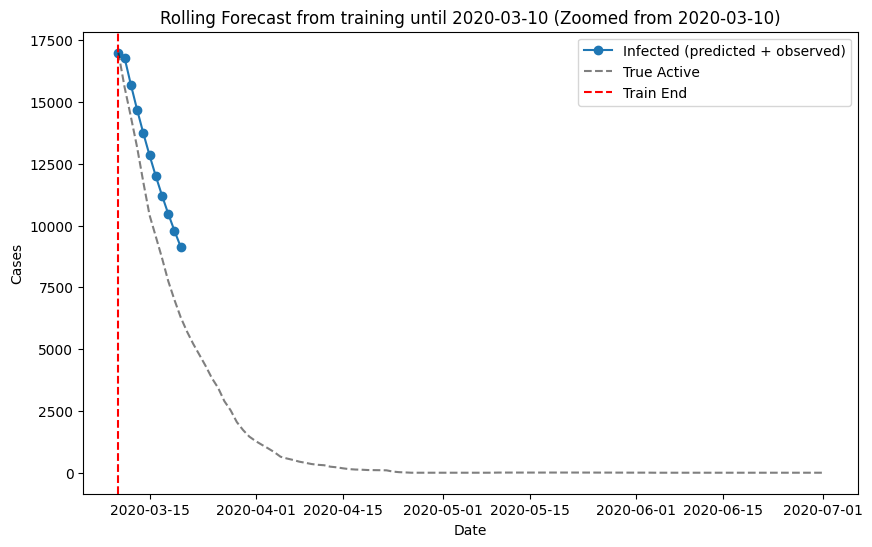

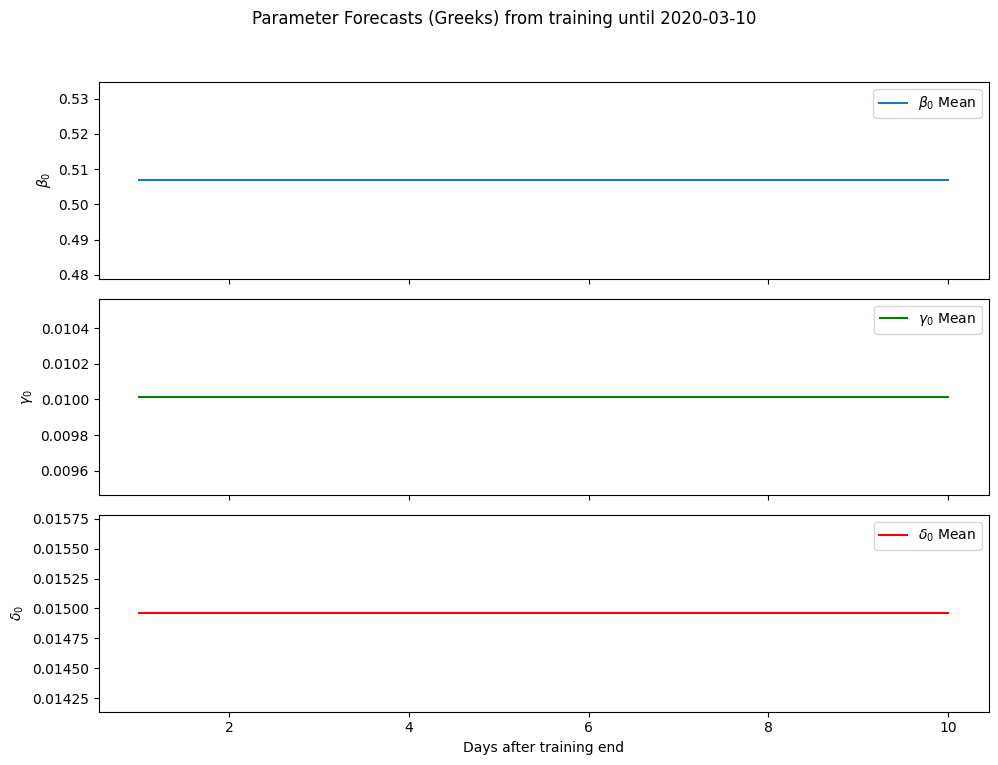

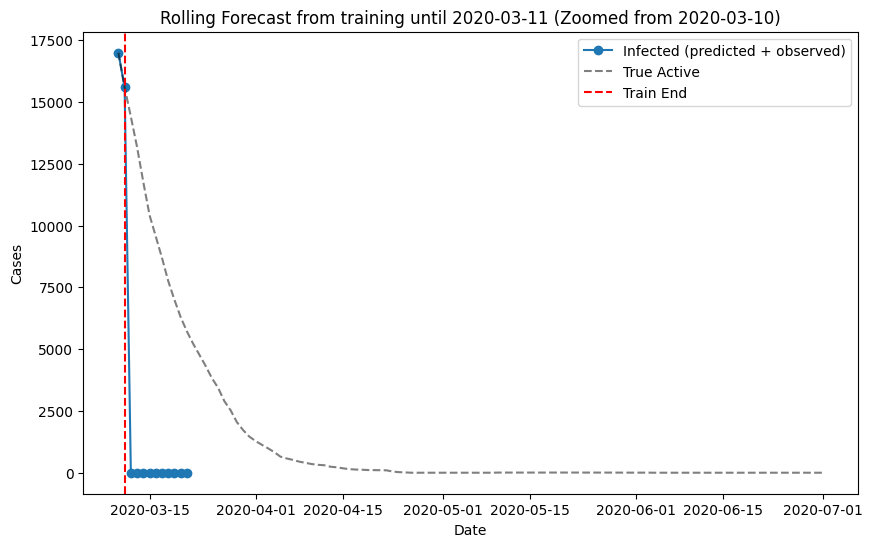

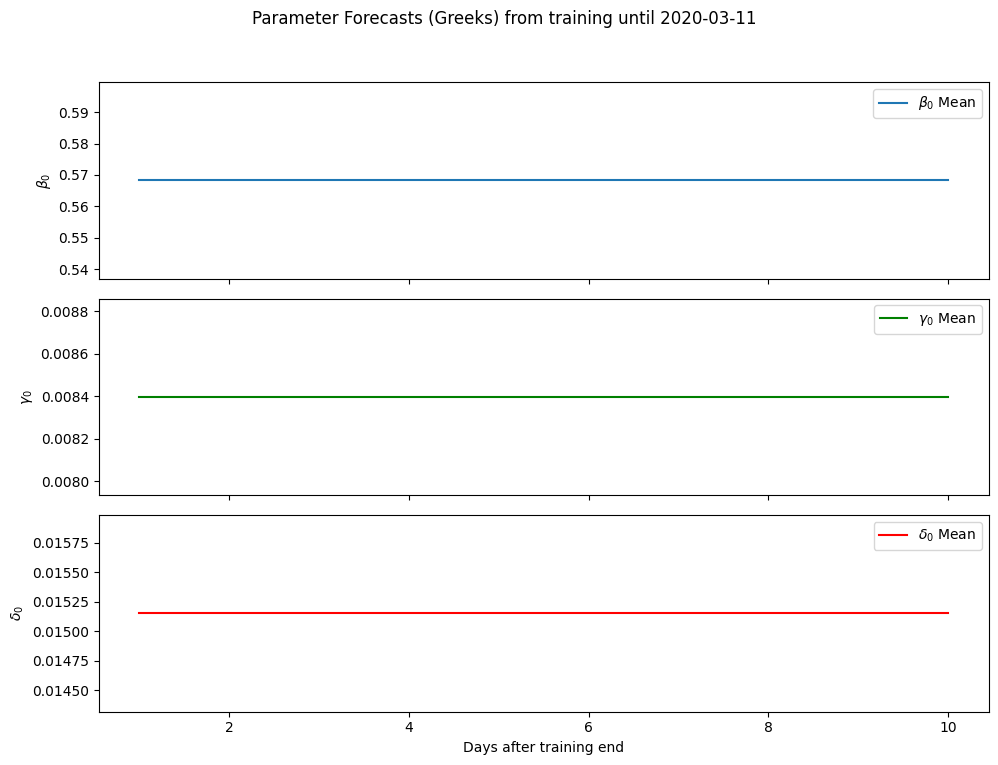

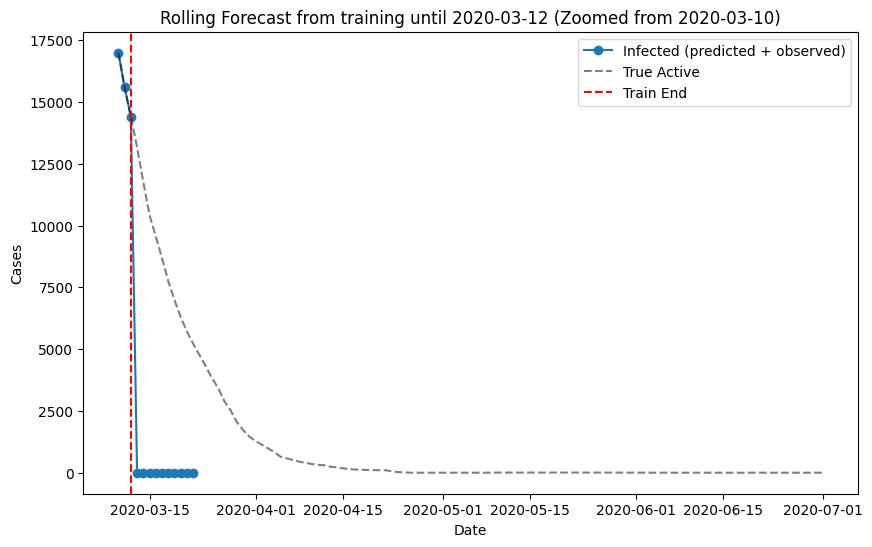

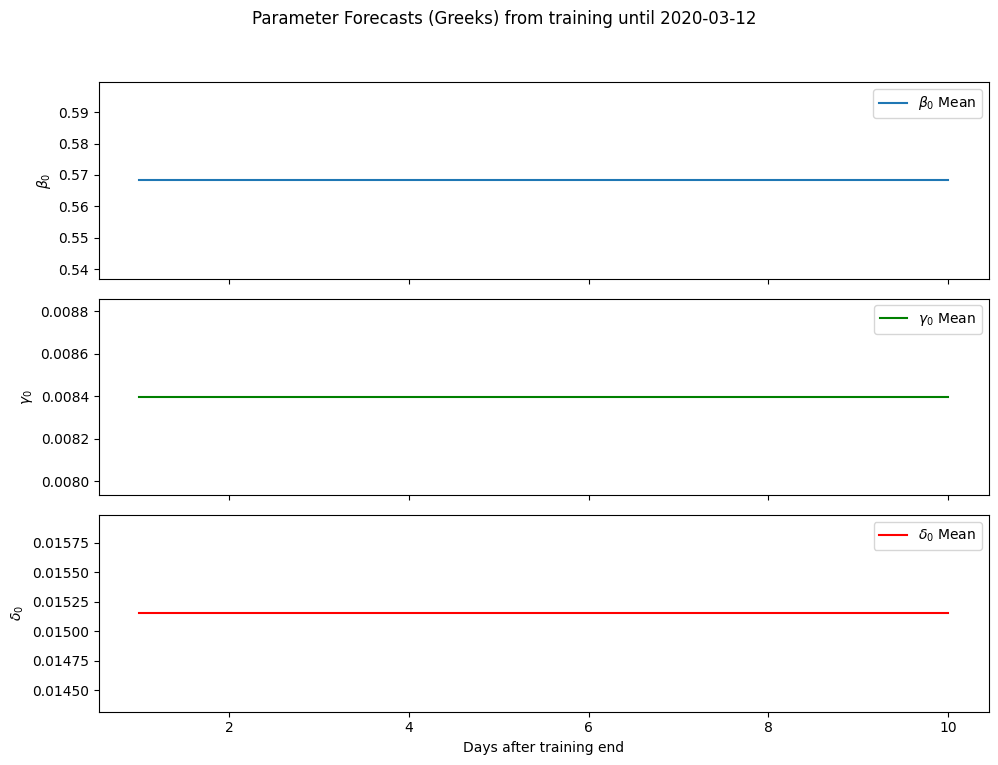

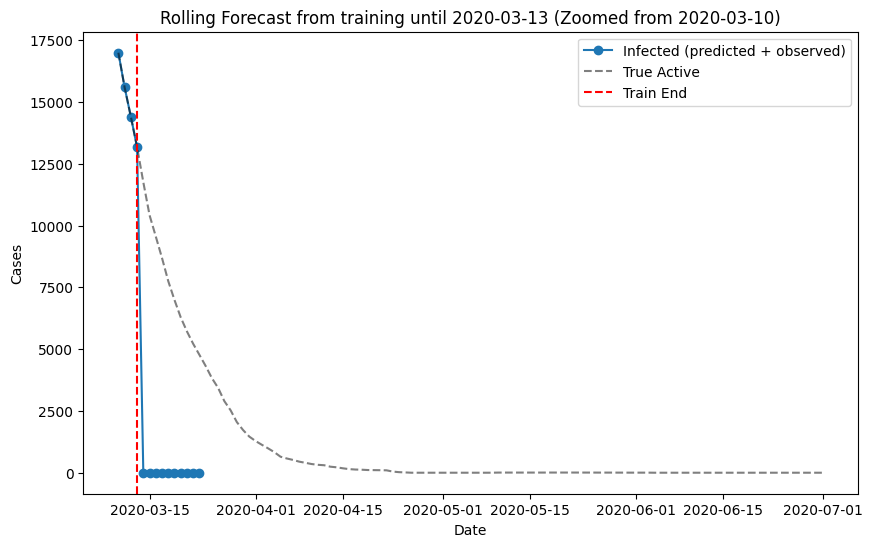

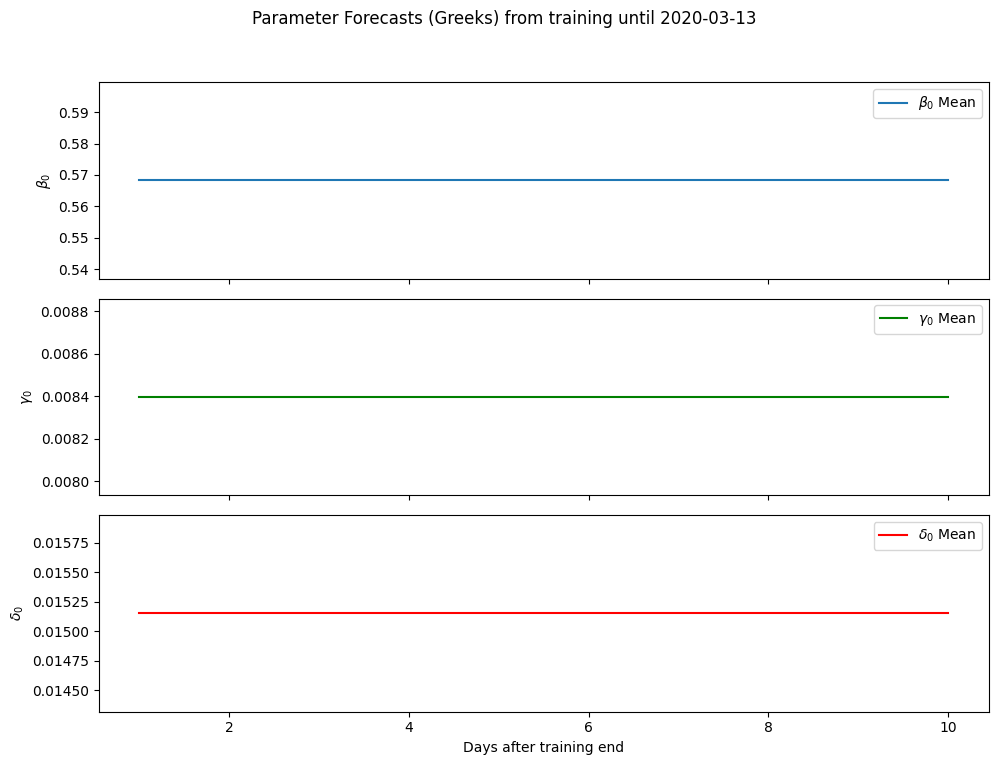

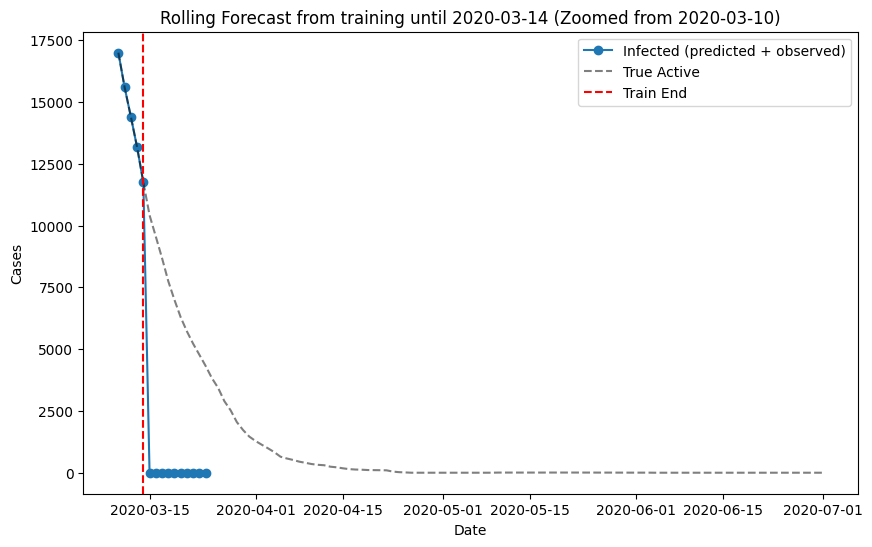

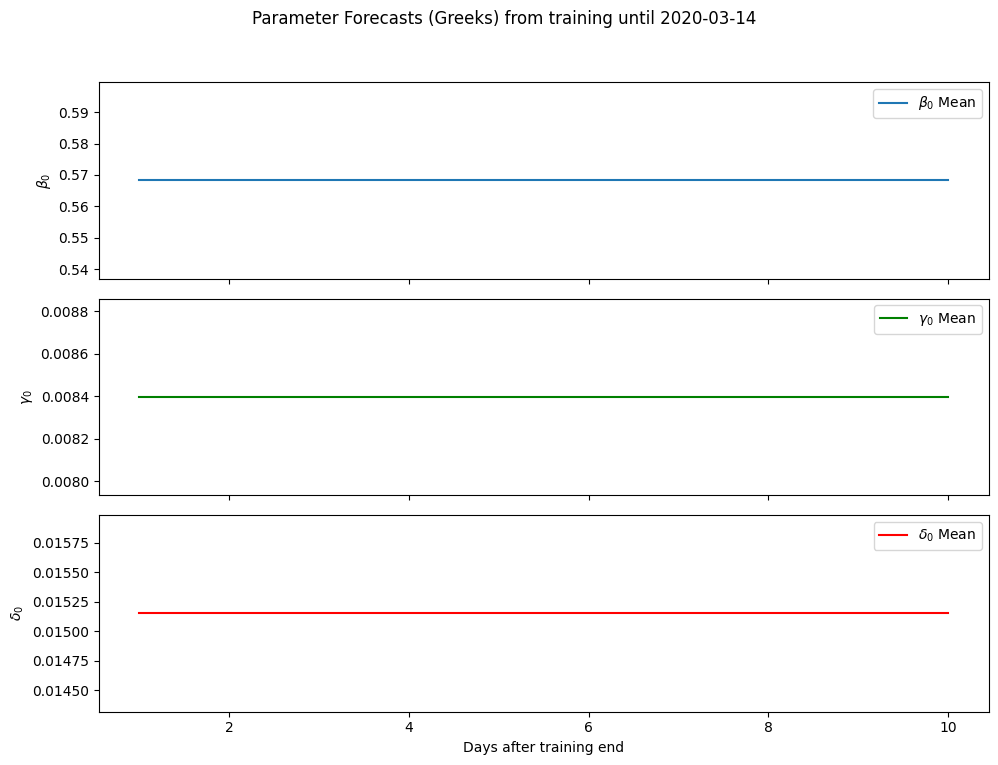

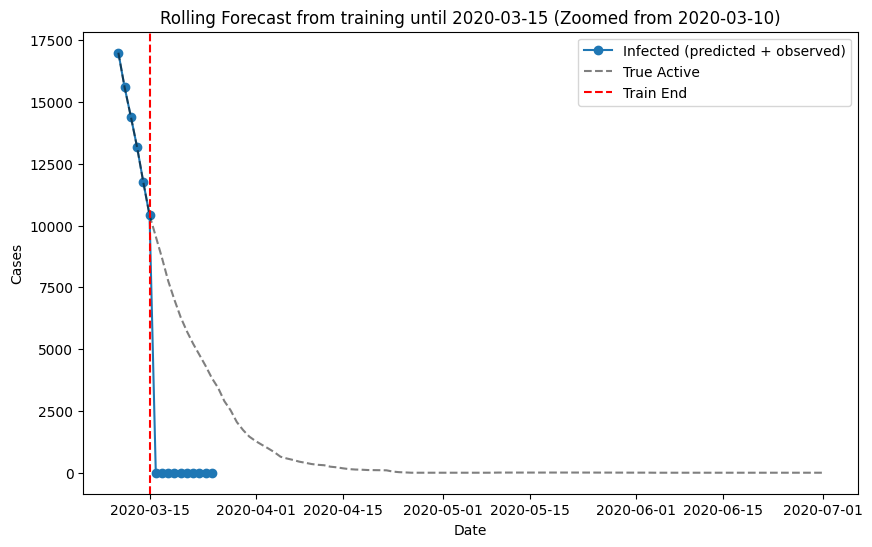

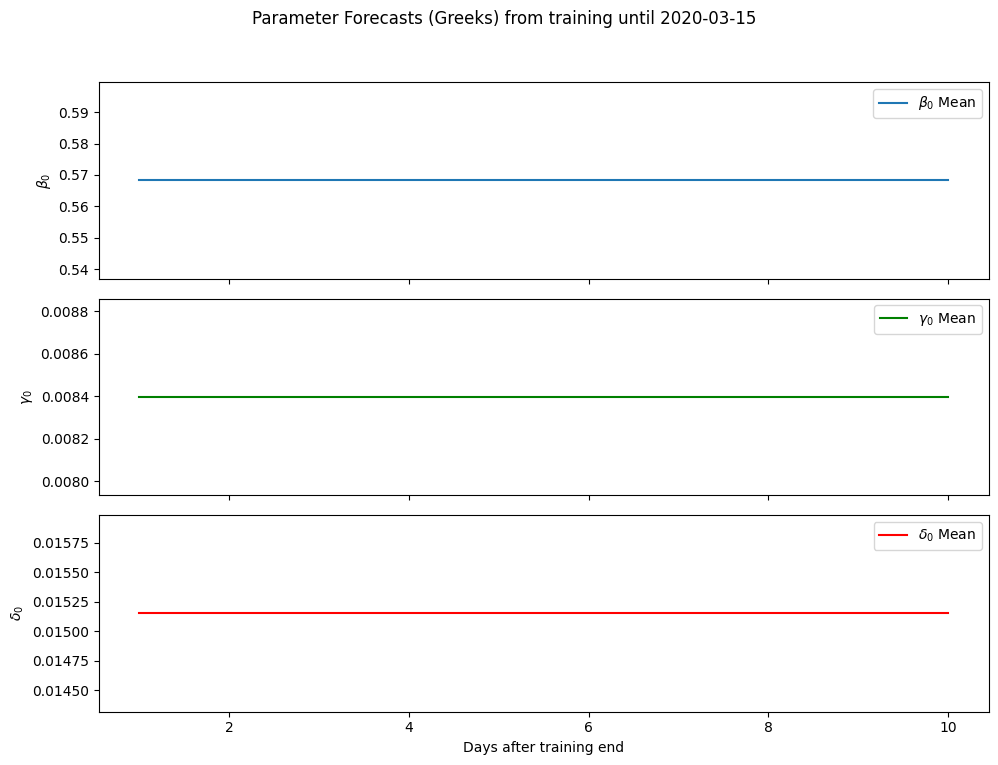

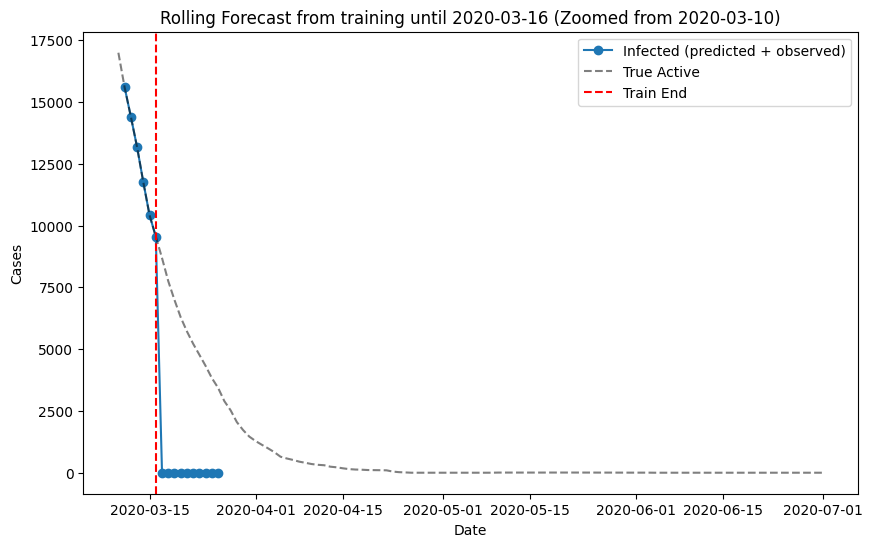

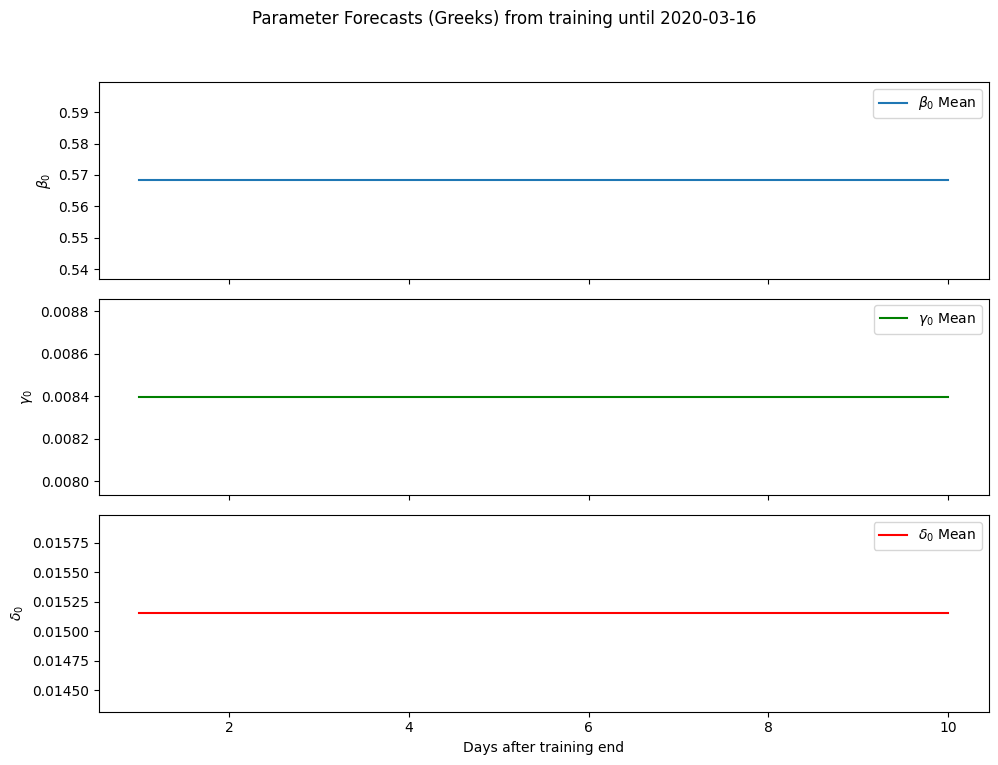

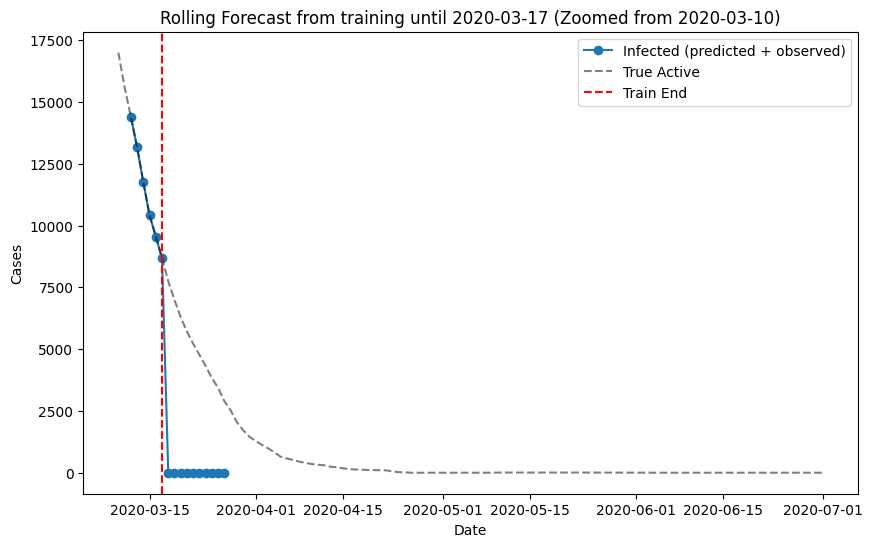

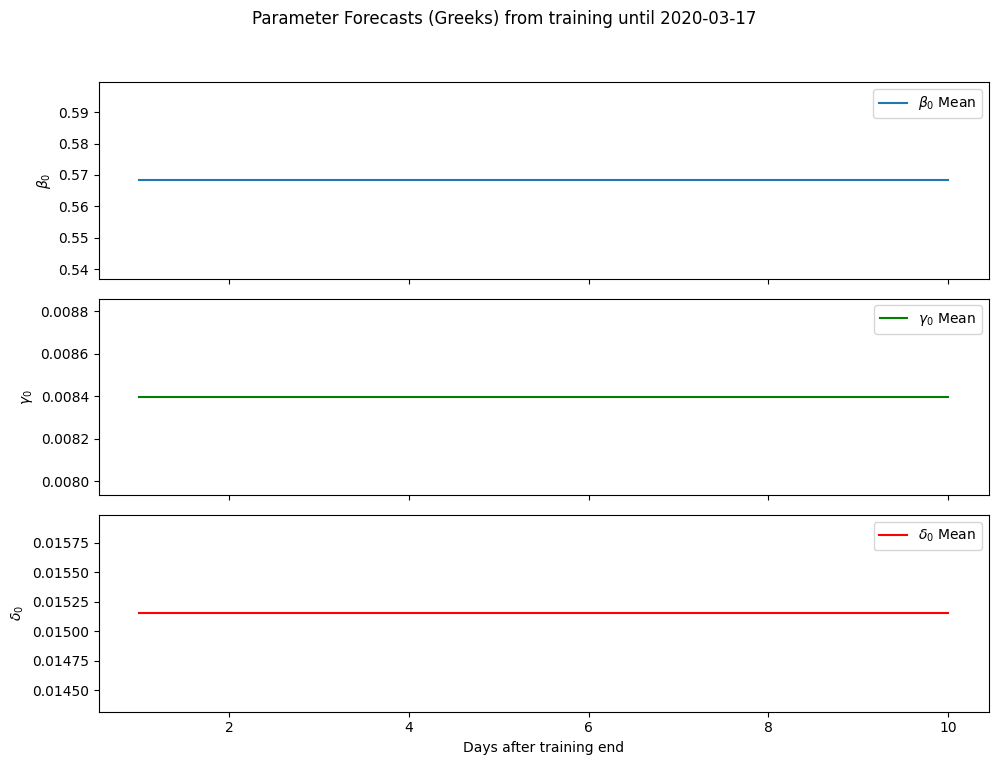

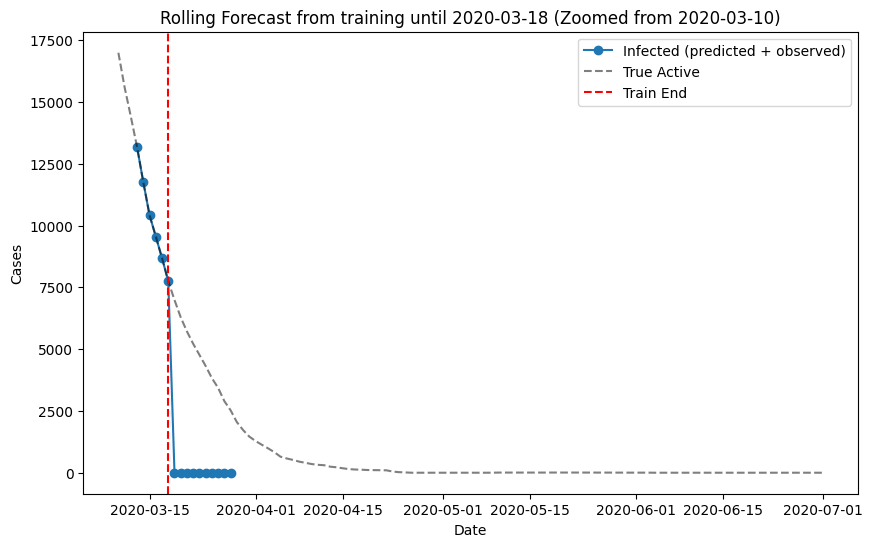

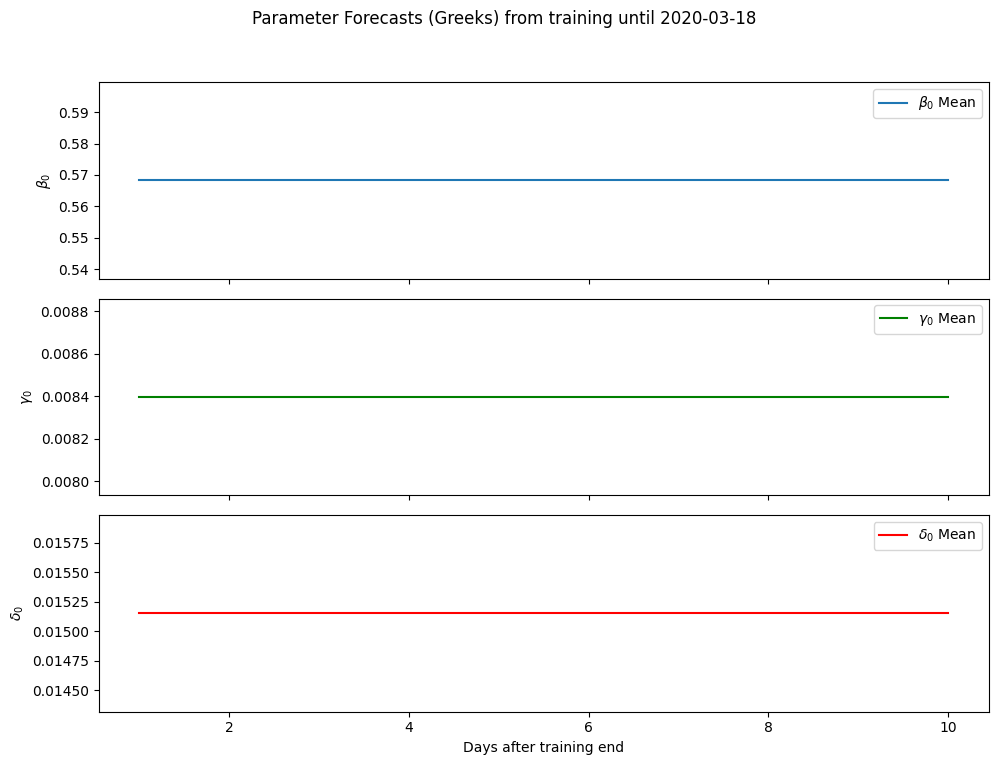

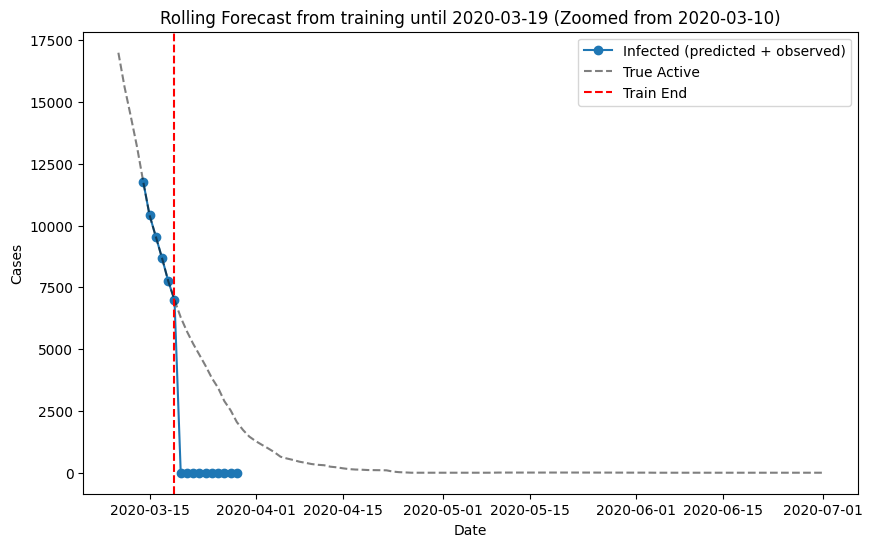

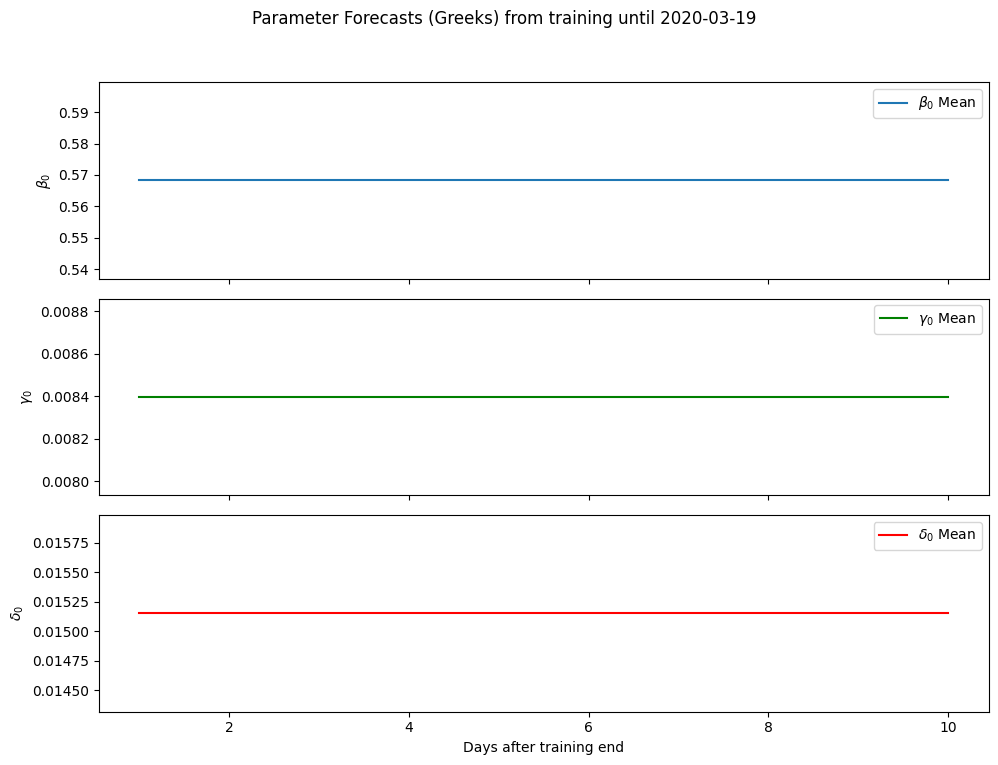

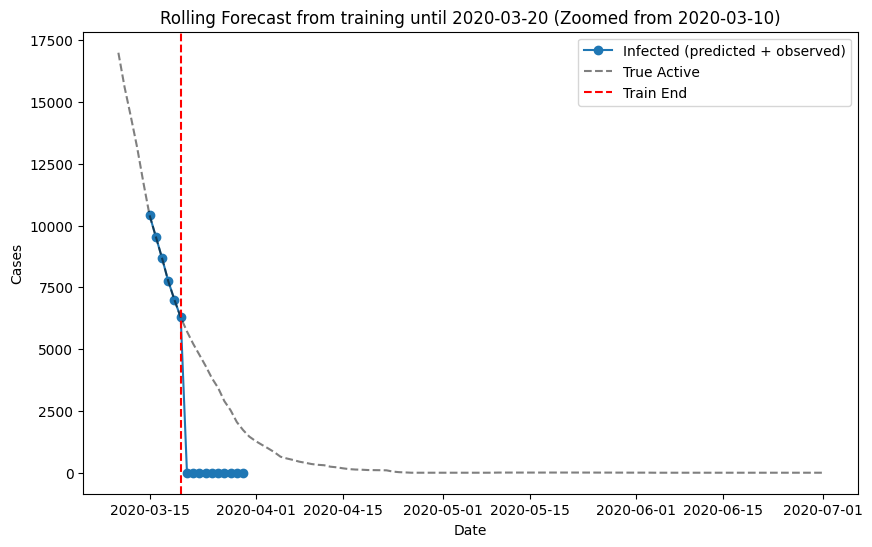

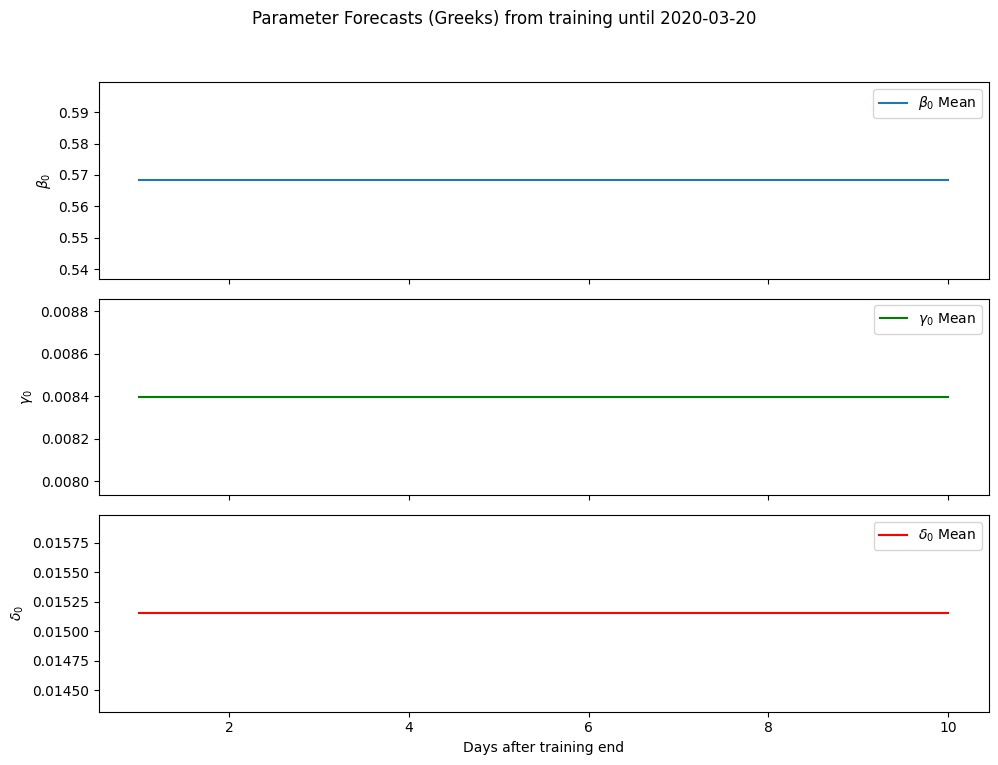

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


forecast_horizon = 10
train_start = pd.Timestamp('2020-01-22')
first_train_end = pd.Timestamp('2020-03-10')
last_train_end = pd.Timestamp('2020-03-20')


N = 59000000  # Hubei population
n_ens = 500
dt = 1.0
t_lockdown = 5
alpha = 1.2


rng = np.random.default_rng(seed=100)


H = np.array([
    [0, 1, 0, 0],  # I
    [0, 0, 1, 0],  # R
    [0, 0, 0, 1],  # D
])


# Use safe exponential to avoid overflow
def safe_exp(x):
    return np.exp(np.clip(x, -700, 700))


def enforce_mass(state_ens, N):
    np.maximum(state_ens, 0.0, out=state_ens)  # Non-negativity
    total_IRD = state_ens[:, 1:].sum(axis=1)
    ok = total_IRD <= N
    state_ens[ok, 0] = N - total_IRD[ok]
    over = ~ok
    if np.any(over):
        scale = (N / total_IRD[over])[:, None]
        state_ens[over, 1:] *= scale
        state_ens[over, 0] = 0.0
    return state_ens


def R_from_obs(y_obs):
    std_devs = 0.1 * np.maximum(y_obs, 1e-2)
    return np.diag(std_devs ** 2)


def sird_step(state, param, N, day, t_lockdown, dt):
    S, I, R, D = state
    beta0, beta1, tau_beta, gamma0, gamma1, tau_gamma, delta0, delta1, tau_delta = param

    beta = beta0 if day < t_lockdown else beta0 * safe_exp(-(day - t_lockdown)/tau_beta) + beta1
    gamma = gamma0 + gamma1 / (1 + safe_exp(- (day - tau_gamma)))
    delta = delta0 if day < t_lockdown else delta0 * safe_exp(-(day - t_lockdown)/tau_delta) + delta1

    dS = - beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dR = gamma * I
    dD = delta * I

    S_new = max(S + dS * dt, 0)
    I_new = max(I + dI * dt, 0)
    R_new = max(R + dR * dt, 0)
    D_new = max(D + dD * dt, 0)

    return np.array([S_new, I_new, R_new, D_new])


def sird_step_vectorized(states_ens, params_ens, N, day, t_lockdown, dt):
    S = states_ens[:, 0]
    I = states_ens[:, 1]
    R = states_ens[:, 2]
    D = states_ens[:, 3]

    beta0 = params_ens[:, 0]
    beta1 = params_ens[:, 1]
    tau_beta = params_ens[:, 2]
    gamma0 = params_ens[:, 3]
    gamma1 = params_ens[:, 4]
    tau_gamma = params_ens[:, 5]
    delta0 = params_ens[:, 6]
    delta1 = params_ens[:, 7]
    tau_delta = params_ens[:, 8]

    beta = np.where(day < t_lockdown,
                    beta0,
                    beta0 * safe_exp(-(day - t_lockdown)/tau_beta) + beta1)
    gamma = gamma0 + gamma1 / (1 + safe_exp(- (day - tau_gamma)))
    delta = np.where(day < t_lockdown,
                     delta0,
                     delta0 * safe_exp(-(day - t_lockdown)/tau_delta) + delta1)

    dS = - beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dR = gamma * I
    dD = delta * I

    S_new = np.maximum(S + dS * dt, 0)
    I_new = np.maximum(I + dI * dt, 0)
    R_new = np.maximum(R + dR * dt, 0)
    D_new = np.maximum(D + dD * dt, 0)

    updated_states = np.stack([S_new, I_new, R_new, D_new], axis=1)
    updated_states = enforce_mass(updated_states, N)
    return updated_states


def initialize_ensemble():
    x0_mean = np.array([N - 399 - 28 - 17, 399, 28, 17])
    state_ens = np.zeros((n_ens, 4))
    for i in range(n_ens):
        perturb = 1 + 0.2 * rng.normal(size=3)
        IRD = np.maximum(x0_mean[1:] * perturb, 0)
        S = max(N - IRD.sum(), 0)
        state_ens[i] = np.hstack([S, IRD])
    state_ens = enforce_mass(state_ens, N)

    param_ens = np.column_stack([
        rng.uniform(0.1, 0.9, n_ens),
        rng.uniform(0.001, 0.002, n_ens),
        rng.uniform(5.0, 20.0, n_ens),
        rng.uniform(0.001, 0.02, n_ens),
        rng.uniform(0.01, 0.1, n_ens),
        rng.uniform(7.0, 40.0, n_ens),
        rng.uniform(0.001, 0.01, n_ens),
        rng.uniform(0.001, 0.002, n_ens),
        rng.uniform(7.0, 20.0, n_ens),
    ])
    return state_ens, param_ens


def enkf_update_one_day(state_ens, param_ens, y_obs, day_index):
    for i in range(n_ens):
        state_ens[i] = sird_step(state_ens[i], param_ens[i], N, day_index, t_lockdown, dt)
    state_ens = enforce_mass(state_ens, N)

    meas_pred = (H @ state_ens.T).T

    Rk = R_from_obs(y_obs)
    obs_perturbed = rng.multivariate_normal(y_obs, Rk, size=n_ens)

    aug_ens = np.hstack([state_ens, param_ens])
    aug_mean = np.mean(aug_ens, axis=0)
    meas_mean = np.mean(meas_pred, axis=0)

    X = aug_ens - aug_mean
    Y = meas_pred - meas_mean

    C_xy = (X.T @ Y) / (n_ens - 1)
    C_yy = (Y.T @ Y) / (n_ens - 1)

    Kk = C_xy @ np.linalg.inv(C_yy + Rk)

    for i in range(n_ens):
        innovation = obs_perturbed[i] - meas_pred[i]
        aug_update = aug_ens[i] + alpha * (Kk @ innovation)
        state_ens[i] = aug_update[:4]
        param_ens[i] = aug_update[4:]
    state_ens = enforce_mass(state_ens, N)

    return state_ens, param_ens


# --- Main incremental filtering and prediction loop ---


# Initialize ensemble at start date
state_ens, param_ens = initialize_ensemble()


rolling_forecasts = []


for train_end in pd.date_range(first_train_end, last_train_end):
    print(f"Training incrementally up to {train_end.date()}")

    train_mask = (filtered_df['Date'] > train_start) & (filtered_df['Date'] <= train_end)
    Y_new_obs = filtered_df.loc[train_mask, ['Active', 'Recovered', 'Deaths']].to_numpy(dtype=float)

    last_day_index = (train_end - train_start).days

    # Assimilate observations day by day
    for day_offset, y_obs in enumerate(Y_new_obs, start=last_day_index - len(Y_new_obs) + 1):
        state_ens, param_ens = enkf_update_one_day(state_ens, param_ens, y_obs, day_offset)

    # Forecast future 10 days without assimilation
    forecast_states = []
    forecast_params = []  # Storage for parameter forecasts
    prev_state_ens = state_ens.copy()
    prev_param_ens = param_ens.copy()
    for step in range(forecast_horizon):
        day_index = last_day_index + step + 1
        prev_state_ens = sird_step_vectorized(prev_state_ens, prev_param_ens, N, day_index, t_lockdown, dt)
        forecast_states.append(np.mean(prev_state_ens, axis=0))
        forecast_params.append(np.mean(prev_param_ens, axis=0))  # Params assumed static in forecast step

    # Prepare data for plotting: 5 days before training end + forecast
    lookback_start = train_end - pd.Timedelta(days=5)
    mask_lookback = (filtered_df['Date'] >= lookback_start) & (filtered_df['Date'] <= train_end)
    lookback_true = filtered_df.loc[mask_lookback, ['Date', 'Active', 'Recovered', 'Deaths']]

    forecast_start = train_end + pd.Timedelta(days=1)
    forecast_dates = pd.date_range(forecast_start, periods=forecast_horizon)

    forecast_df = pd.DataFrame(forecast_states, columns=['S', 'I', 'R', 'D'])
    forecast_df['Date'] = forecast_dates

    plot_df = pd.concat([
        lookback_true.rename(columns={'Active': 'I', 'Recovered': 'R', 'Deaths': 'D'})[['Date', 'I', 'R', 'D']],
        forecast_df[['Date', 'I', 'R', 'D']]
    ], ignore_index=True)

    rolling_forecasts.append({
        'train_end': train_end,
        'plot_data': plot_df,
        'param_forecasts': np.array(forecast_params)  # shape (forecast_horizon, n_params)
    })


zoom_start_date = pd.Timestamp('2020-03-10')

for entry in rolling_forecasts:
    train_end = entry['train_end']
    df_plot = entry['plot_data']

    # Filter to zoom_start_date onwards
    df_plot_zoom = df_plot[df_plot['Date'] >= zoom_start_date]

    plt.figure(figsize=(10,6))
    plt.title(f'Rolling Forecast from training until {train_end.date()} (Zoomed from {zoom_start_date.date()})')
    plt.plot(df_plot_zoom['Date'], df_plot_zoom['I'], '-o', label='Infected (predicted + observed)')

    # Also show true active cases from zoom_start_date onwards for reference
    true_zoom = filtered_df[filtered_df['Date'] >= zoom_start_date]
    plt.plot(true_zoom['Date'], true_zoom['Active'], 'k--', alpha=0.5, label='True Active')

    plt.axvline(x=train_end, color='r', linestyle='--', label='Train End')
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.legend()
    plt.show()


    # --- Plot Greeks/parameters per forecast ---
    param_forecasts = entry['param_forecasts']
    days = range(1, forecast_horizon + 1)

    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f"Parameter Forecasts (Greeks) from training until {train_end.date()}")

    # beta0 (parameter index 0)
    axs[0].plot(days, param_forecasts[:, 0], label=r'$\beta_0$ Mean')
    axs[0].set_ylabel(r'$\beta_0$')
    axs[0].legend()

    # gamma0 (parameter index 3)
    axs[1].plot(days, param_forecasts[:, 3], label=r'$\gamma_0$ Mean', color='green')
    axs[1].set_ylabel(r'$\gamma_0$')
    axs[1].legend()

    # delta0 (parameter index 6)
    axs[2].plot(days, param_forecasts[:, 6], label=r'$\delta_0$ Mean', color='red')
    axs[2].set_xlabel('Days after training end')
    axs[2].set_ylabel(r'$\delta_0$')
    axs[2].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
